In [1]:
import pandas as pd
import numpy as ny

In [2]:
df=pd.read_csv('cleaned_data/merged_final.csv')
df.head()

,WORK_DATE,attendance,DEB_TIME,DEB_TIME_HOUR,FIN_TIME,ENTITY_DESCRIPTION_SHORT,WAIT_TIME_MAX,NB_UNITS,GUEST_CARRIED,CAPACITY,...,wind_gust,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_main,weather_description,REF_CLOSING_DESCRIPTION,reference
0,2018-06-01,46804.0,2018-06-01 09:00:00,9.0,2018-06-01 09:15:00,Bumper Cars,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,100,Clouds,overcast clouds,Overture,not in ES
1,2018-06-01,46804.0,2018-06-01 09:15:00,9.0,2018-06-01 09:30:00,Bumper Cars,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,100,Clouds,overcast clouds,Overture,not in ES
2,2018-06-01,46804.0,2018-06-01 09:30:00,9.0,2018-06-01 09:45:00,Bumper Cars,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,100,Clouds,overcast clouds,Overture,not in ES
3,2018-06-01,46804.0,2018-06-01 09:45:00,9.0,2018-06-01 10:00:00,Bumper Cars,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,100,Clouds,overcast clouds,Overture,not in ES
4,2018-06-01,46804.0,2018-06-01 10:00:00,10.0,2018-06-01 10:15:00,Bumper Cars,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,100,Clouds,overcast clouds,Overture,not in ES


In [3]:
df.columns

Index(['WORK_DATE', 'attendance', 'DEB_TIME', 'DEB_TIME_HOUR', 'FIN_TIME',
       'ENTITY_DESCRIPTION_SHORT', 'WAIT_TIME_MAX', 'NB_UNITS',
       'GUEST_CARRIED', 'CAPACITY', 'ADJUST_CAPACITY', 'OPEN_TIME', 'UP_TIME',
       'DOWNTIME', 'NB_MAX_UNIT', 'SUM_UP_DOWN', 'NIGHT_SHOW', 'PARADE_1',
       'PARADE_2', 'temp', 'visibility', 'dew_point', 'feels_like', 'temp_min',
       'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg',
       'wind_gust', 'rain_1h', 'rain_3h', 'snow_1h', 'snow_3h', 'clouds_all',
       'weather_main', 'weather_description', 'REF_CLOSING_DESCRIPTION',
       'reference'],
      dtype='object')

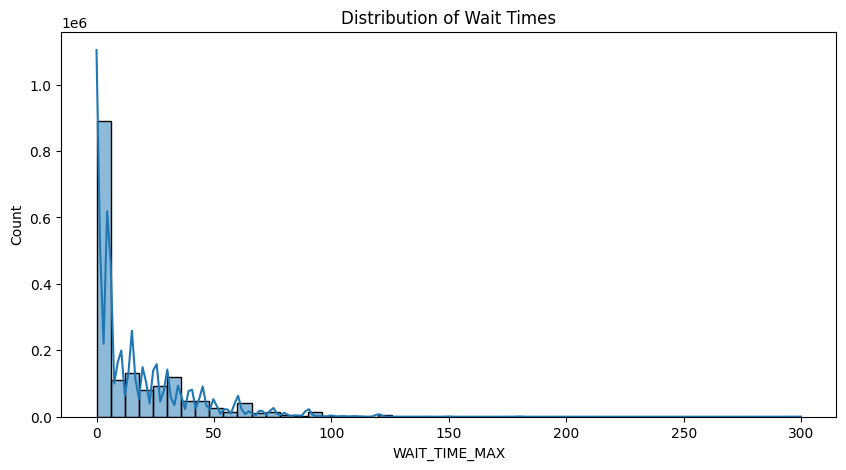

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.histplot(df["WAIT_TIME_MAX"], bins=50, kde=True)
plt.title("Distribution of Wait Times")
plt.show()


In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["attraction_id"] = le.fit_transform(df["ENTITY_DESCRIPTION_SHORT"])
metadata = df[["WORK_DATE", "attraction_id", "DEB_TIME", "ENTITY_DESCRIPTION_SHORT"]].copy()
df.drop(columns=["ENTITY_DESCRIPTION_SHORT"], inplace=True)

In [6]:
df["weather_main"] = le.fit_transform(df["weather_main"])
df["weather_description"] = le.fit_transform(df["weather_description"])

In [7]:
df["day_of_week"] = pd.to_datetime(df["WORK_DATE"]).dt.dayofweek  # Monday=0, Sunday=6
df["is_weekend"] = df["day_of_week"].apply(lambda x: 1 if x >= 5 else 0)
df["is_holiday"] = df["WORK_DATE"].isin(["2024-07-04", "2024-12-25"]).astype(int)  # Add actual holiday dates

In [8]:
df["WAIT_LAG_1"] = df.groupby("attraction_id")["WAIT_TIME_MAX"].shift(1)
df["WAIT_LAG_2"] = df.groupby("attraction_id")["WAIT_TIME_MAX"].shift(2)
df["WAIT_LAG_3"] = df.groupby("attraction_id")["WAIT_TIME_MAX"].shift(3)
df["WAIT_LAG_7"] = df.groupby("attraction_id")["WAIT_TIME_MAX"].shift(7)

In [9]:
df["ROLLING_WAIT_3"] = df.groupby("attraction_id")["WAIT_TIME_MAX"].transform(lambda x: x.rolling(3, min_periods=1).mean())
df["ROLLING_WAIT_7"] = df.groupby("attraction_id")["WAIT_TIME_MAX"].transform(lambda x: x.rolling(7, min_periods=1).mean())

In [10]:
import numpy as np

def time_to_datetime(row, event_column):
    """Convert HH:MM:SS time (from parade/night show) into absolute datetime based on DEB_TIME."""
    time_str = row[event_column]
    if pd.isna(time_str) or "no parade" in str(time_str).lower():
        return np.nan  # Mark as missing if no event
    
    try:
        # Extract only HH:MM and combine with DEB_TIME's date
        event_time = pd.to_datetime(time_str, format="%H:%M:%S").time()
        return pd.Timestamp.combine(row["DEB_TIME"].date(), event_time)
    except:
        return np.nan

# Ensure DEB_TIME is a datetime object
df["DEB_TIME"] = pd.to_datetime(df["DEB_TIME"], errors="coerce")

# Convert parade & night show times to absolute datetime
df["PARADE_1_TIME"] = df.apply(lambda row: time_to_datetime(row, "PARADE_1"), axis=1)
df["PARADE_2_TIME"] = df.apply(lambda row: time_to_datetime(row, "PARADE_2"), axis=1)
df["NIGHT_SHOW_TIME"] = df.apply(lambda row: time_to_datetime(row, "NIGHT_SHOW"), axis=1)

# Compute time differences in **minutes**
df["TIME_TO_PARADE_1"] = (df["PARADE_1_TIME"] - df["DEB_TIME"]).dt.total_seconds() / 60
df["TIME_TO_PARADE_2"] = (df["PARADE_2_TIME"] - df["DEB_TIME"]).dt.total_seconds() / 60
df["TIME_TO_NIGHT_SHOW"] = (df["NIGHT_SHOW_TIME"] - df["DEB_TIME"]).dt.total_seconds() / 60

# Fill missing values (e.g., no parade that day) with a large number
df.fillna({"TIME_TO_PARADE_1": 9999, "TIME_TO_PARADE_2": 9999, "TIME_TO_NIGHT_SHOW": 9999}, inplace=True)

# Define a **proximity window** (e.g., within 60 minutes)
proximity_window = 60  

df["NEAR_PARADE_1"] = (df["TIME_TO_PARADE_1"].abs() <= proximity_window).astype(int)
df["NEAR_PARADE_2"] = (df["TIME_TO_PARADE_2"].abs() <= proximity_window).astype(int)
df["NEAR_NIGHT_SHOW"] = (df["TIME_TO_NIGHT_SHOW"].abs() <= proximity_window).astype(int)

print("✅ Event time processing complete!")



✅ Event time processing complete!


In [11]:
# Sort the dataset by WORK_DATE before splitting
df = df.sort_values("DEB_TIME").reset_index(drop=True)

In [12]:
from sklearn.metrics import mean_squared_log_error


# Baseline: Predict the average wait time for every attraction
y_baseline = df.groupby("attraction_id")["WAIT_TIME_MAX"].transform("mean")

# Compute RMSLE
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, np.maximum(y_pred, 0)))  # Ensure predictions are non-negative

baseline_rmsle = rmsle(df["WAIT_TIME_MAX"], y_baseline)
print(f"Baseline RMSLE: {baseline_rmsle:.4f}")


Baseline RMSLE: 1.5753


In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Select features and target
features = ["attendance", "DEB_TIME_HOUR", "NB_UNITS", "GUEST_CARRIED", "CAPACITY", "UP_TIME", "DOWNTIME", "temp", "humidity", "wind_speed","NEAR_NIGHT_SHOW","NEAR_PARADE_1","NEAR_PARADE_2"]
X = df[features]
y = df["WAIT_TIME_MAX"]

# Train-test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train model
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Compute RMSLE
rf_rmsle = rmsle(y_test, y_pred_rf)
print(f"Random Forest RMSLE: {rf_rmsle:.4f}")


Random Forest RMSLE: 0.6882


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_log_error
from torch.utils.data import Dataset, DataLoader

In [16]:
def rmsle_loss(y_true, y_pred):
    epsilon = 1e-6  # Small value to prevent log(0)
    return torch.sqrt(torch.mean((torch.log(y_pred + 1 + epsilon) - torch.log(y_true + 1 + epsilon))**2))

In [17]:
#features = ["attraction_id", "DEB_TIME_HOUR", "NB_UNITS", 
            #"CAPACITY", "UP_TIME", "DOWNTIME", "temp", 
            #"humidity", "wind_speed", "WAIT_LAG_1", "WAIT_LAG_2", "WAIT_LAG_3"]
features = ["attraction_id", "attendance", "DEB_TIME_HOUR", "NB_UNITS", 
            "GUEST_CARRIED", "CAPACITY", "UP_TIME", "DOWNTIME", "temp", 
            "humidity", "wind_speed", "WAIT_LAG_1", "WAIT_LAG_2", "WAIT_LAG_3","TIME_TO_PARADE_1","TIME_TO_PARADE_2","TIME_TO_NIGHT_SHOW"]
target = "WAIT_TIME_MAX"

In [18]:
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

In [19]:
# Ensure metadata is correctly formatted before sequencing
metadata["DEB_TIME"] = pd.to_datetime(metadata["DEB_TIME"])  # Ensure correct type
print(metadata.dtypes)  # Confirm it's datetime64[ns]
print(metadata.head())  # Verify correct values



WORK_DATE                           object
attraction_id                        int64
DEB_TIME                    datetime64[ns]
ENTITY_DESCRIPTION_SHORT            object
dtype: object
    WORK_DATE  attraction_id            DEB_TIME ENTITY_DESCRIPTION_SHORT
0  2018-06-01              0 2018-06-01 09:00:00              Bumper Cars
1  2018-06-01              0 2018-06-01 09:15:00              Bumper Cars
2  2018-06-01              0 2018-06-01 09:30:00              Bumper Cars
3  2018-06-01              0 2018-06-01 09:45:00              Bumper Cars
4  2018-06-01              0 2018-06-01 10:00:00              Bumper Cars


In [20]:
def create_sequences_with_metadata(data, metadata, seq_length):
    X, y, meta = [], [], []
    
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length][features].values.astype(np.float32))  # Explicitly convert to float32
        y.append(np.float32(data.iloc[i+seq_length][target]))  # Ensure y is float32
        meta.append(metadata.iloc[i+seq_length].values)  # Store metadata for y

    return np.array(X), np.array(y), np.array(meta, dtype=object)  # Ensure metadata remains as object (not numeric)

sequence_length = 10

# Now create sequences
X_lstm, y_lstm, meta_lstm = create_sequences_with_metadata(df, metadata, sequence_length)


In [22]:
print(f"X_lstm shape: {X_lstm.shape}")  # Expected: (rows, seq_length, features)
print(f"y_lstm shape: {y_lstm.shape}")  # Expected: (rows,)
print(f"meta_lstm shape: {meta_lstm.shape}")  # Expected: (rows, meta_columns)

meta_df = pd.DataFrame(meta_lstm, columns=["WORK_DATE", "attraction_id", "DEB_TIME", "ENTITY_DESCRIPTION_SHORT"])

print(meta_df.dtypes)  # Confirm DEB_TIME is still datetime64[ns]
print(meta_df.head())  # Ensure format is correct


X_lstm shape: (1656268, 10, 17)
y_lstm shape: (1656268,)
meta_lstm shape: (1656268, 4)
WORK_DATE                           object
attraction_id                       object
DEB_TIME                    datetime64[ns]
ENTITY_DESCRIPTION_SHORT            object
dtype: object
    WORK_DATE attraction_id            DEB_TIME ENTITY_DESCRIPTION_SHORT
0  2018-06-01             0 2018-06-01 11:30:00              Bumper Cars
1  2018-06-01             0 2018-06-01 11:45:00              Bumper Cars
2  2018-06-01             0 2018-06-01 12:00:00              Bumper Cars
3  2018-06-01             0 2018-06-01 12:15:00              Bumper Cars
4  2018-06-01             0 2018-06-01 12:30:00              Bumper Cars


In [23]:
from sklearn.model_selection import train_test_split

# Ensure DEB_TIME is datetime for sorting
meta_df["DEB_TIME"] = pd.to_datetime(meta_df["DEB_TIME"])

# Flatten X_lstm for stratified split
data_combined = pd.concat([
    pd.DataFrame(X_lstm.reshape(X_lstm.shape[0], -1)),  # Flatten to (rows, 10*17)
    pd.Series(y_lstm, name="WAIT_TIME_MAX"),  # Keep y_lstm separate but aligned
    meta_df  # Keep metadata separate
], axis=1)

split_ratio = 0.1  # 10% for test set
split_index = int(len(data_combined) * (1 - split_ratio))

# Ensure chronological order
data_combined = data_combined.sort_values(by="DEB_TIME").reset_index(drop=True)

print(f"Total rows in dataset: {len(data_combined)}")
print(f"Split index (90% train): {split_index}")
print(f"Rows before Split Index: {len(data_combined.iloc[:split_index])}")
print(f"Rows after Split Index: {len(data_combined.iloc[split_index:])}")


Total rows in dataset: 1656268
Split index (90% train): 1490641
Rows before Split Index: 1490641
Rows after Split Index: 165627


In [24]:
# Stratified sampling on the last portion while maintaining time order
train_df, test_df = train_test_split(
    data_combined.iloc[split_index:],  # Select last portion
    test_size=split_ratio,
    random_state=42,
    stratify=data_combined.iloc[split_index:]["attraction_id"]  # Ensure attraction balance
)

# Merge the stratified test set back with the earlier dataset
test_df = pd.concat([data_combined.iloc[:split_index], test_df]).reset_index(drop=True)

# Swap train and test
train_df, test_df = test_df, train_df


# Remove unnecessary columns and reshape X_train properly
X_train = train_df.iloc[:, :10*17].values.reshape(-1, 10, 17)  # Reshape back
y_train = train_df["WAIT_TIME_MAX"].values

X_test = test_df.iloc[:, :10*17].values.reshape(-1, 10, 17)  # Reshape back
y_test = test_df["WAIT_TIME_MAX"].values

meta_train = train_df[["WORK_DATE", "ENTITY_DESCRIPTION_SHORT", "DEB_TIME", "attraction_id"]].values
meta_test = test_df[["WORK_DATE", "ENTITY_DESCRIPTION_SHORT", "DEB_TIME", "attraction_id"]].values

print("✅ Stratified Train-Test Split Done! Attractions are well-represented and sorted by time.")

print(f"X_train shape: {X_train.shape}")  # Expected (train_rows, 10, 17)
print(f"X_test shape: {X_test.shape}")  # Expected (test_rows, 10, 17)
print(f"y_train shape: {y_train.shape}")  # Expected (train_rows,)
print(f"y_test shape: {y_test.shape}")  # Expected (test_rows,)
print(f"Meta_train shape: {meta_train.shape}")  # Expected (train_rows, 4)
print(f"Meta_test shape: {meta_test.shape}")  # Expected (test_rows, 4)")


✅ Stratified Train-Test Split Done! Attractions are well-represented and sorted by time.
X_train shape: (1507204, 10, 17)
X_test shape: (149064, 10, 17)
y_train shape: (1507204,)
y_test shape: (149064,)
Meta_train shape: (1507204, 4)
Meta_test shape: (149064, 4)


In [25]:
print("Train DEB_TIME range:", meta_train[0, 2], "to", meta_train[-1, 2])
print("Test DEB_TIME range:", meta_test[0, 2], "to", meta_test[-1, 2])


Train DEB_TIME range: 2018-06-01 09:00:00 to 2022-04-13 12:45:00
Test DEB_TIME range: 2022-04-19 12:30:00 to 2022-04-21 15:30:00


In [26]:
test_df["ENTITY_DESCRIPTION_SHORT"].value_counts()

ENTITY_DESCRIPTION_SHORT
Flying Coaster      5870
Circus Train        5870
Giant Wheel         5870
Dizzy Dropper       5870
Bungee Jump         5870
Go-Karts            5869
Rapids Ride         5869
Merry Go Round      5868
Drop Tower          5868
Spinning Coaster    5868
Free Fall           5868
Bumper Cars         5867
Water Ride          5867
Haunted House       5867
Zipline             5866
Kiddie Coaster      5866
Inverted Coaster    5866
Superman Ride       5864
Roller Coaster      5864
Swing Ride          5864
Oz Theatre          5864
Spiral Slide        5863
Himalaya Ride       5861
Giga Coaster        5861
Crazy Dance         5859
Vertical Drop       2405
Name: count, dtype: int64

In [27]:
class WaitTimeDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    

train_dataset = WaitTimeDataset(X_train, y_train)
test_dataset = WaitTimeDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [28]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])  # Take last time step's output
        
        # Apply ReLU to prevent negative values
        out = torch.relu(out)
        
        # Clamp values to avoid extreme outputs
        out = torch.clamp(out, min=0, max=1e6)  # Prevent explosion
        
        # Replace NaN or Inf values
        out = torch.nan_to_num(out, nan=0.0, posinf=1e6, neginf=0.0)
        
        return out



def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if "weight_ih" in name:
                nn.init.xavier_uniform_(param)  # Xavier for input-hidden weights
            elif "weight_hh" in name:
                nn.init.orthogonal_(param)  # Orthogonal for hidden-hidden weights
            elif "bias" in name:
                nn.init.zeros_(param)  # Zero biases to prevent bad gradients

In [29]:
input_size = len(features)
hidden_size = 50
num_layers = 2
output_size = 1
num_epochs = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)

# Apply to model
model.apply(weights_init)

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = rmsle_loss  # Using RMSLE instead of MSE or MAE

In [30]:
train_losses = []  # Store loss values for visualization

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # ✅ Replace NaNs and infinite values
        X_batch = torch.nan_to_num(X_batch, nan=0.0, posinf=1.0, neginf=-1.0)
        y_batch = torch.nan_to_num(y_batch, nan=0.0, posinf=1.0, neginf=-1.0)

        optimizer.zero_grad()
        y_pred = model(X_batch).squeeze()

        # ✅ Clip predictions to avoid log(0) issues
        y_pred = torch.clamp(y_pred, min=1e-6)

        loss = loss_function(y_pred, y_batch)

        # ✅ Skip bad batches (avoid NaN loss propagation)
        if not torch.isfinite(loss):
            print(f"Skipping batch due to NaN loss!")
            continue

        loss.backward()

        # ✅ Gradient Clipping to prevent instability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)  # Compute average loss for epoch
    train_losses.append(train_loss)  # Store loss for visualization
 
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}")

Epoch 1/10 - Train Loss: 1.1933
Epoch 2/10 - Train Loss: 1.1814
Epoch 3/10 - Train Loss: 1.1781
Epoch 4/10 - Train Loss: 1.1761
Epoch 5/10 - Train Loss: 1.1745
Epoch 6/10 - Train Loss: 1.1730
Epoch 7/10 - Train Loss: 1.1720
Epoch 8/10 - Train Loss: 1.1708
Epoch 9/10 - Train Loss: 1.1700
Epoch 10/10 - Train Loss: 1.1692


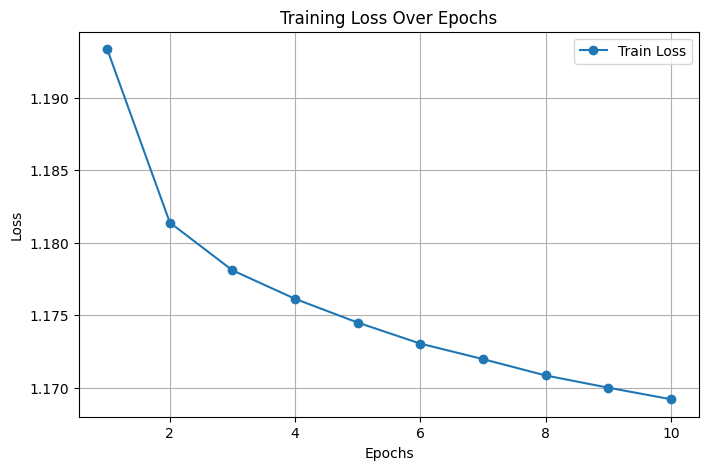

In [31]:
import matplotlib.pyplot as plt

# Assuming `train_losses` is a list storing loss per epoch
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker="o", linestyle="-", label="Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [32]:
model.eval()
y_pred_list = []

with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_pred = model(X_batch).squeeze().cpu().numpy()
        y_pred_list.append(y_pred)  # Append batch-wise predictions

# **Concatenate all batch predictions into one array**
y_pred = np.concatenate(y_pred_list, axis=0)


In [33]:
y_pred = np.maximum(y_pred, 0)  # Clamp negative values to 0
y_pred = torch.tensor(y_pred, dtype=torch.float32)

test_rmsle = rmsle_loss(torch.tensor(y_test, dtype=torch.float32), y_pred).item()
print(f"Test RMSLE: {test_rmsle:.4f}")

Test RMSLE: 1.1985


In [34]:
import torch.nn.functional as F
# Compute MAE
test_mae = F.l1_loss(y_pred, torch.tensor(y_test, dtype=torch.float32)).item()

print(f"Test MAE: {test_mae:.4f}")

Test MAE: 12.0077


In [35]:
# Save the trained LSTM model
model_path = "waiting_time_model3.pth"
torch.save(model.state_dict(), model_path)

print(f"Model saved successfully as {model_path}")

Model saved successfully as waiting_time_model3.pth


In [36]:
predictions_df = pd.DataFrame(meta_test, columns=["WORK_DATE", "attraction_id", "DEB_TIME_HOUR", "ENTITY_DESCRIPTION_SHORT"])
predictions_df["y_test"] = y_test.flatten()
predictions_df["y_pred"] = y_pred.flatten()
predictions_df["error"] = abs(predictions_df["y_test"] - predictions_df["y_pred"])

# Save predictions with metadata
predictions_df.to_csv("predictions_with_metadata2.csv", index=False)
print("✅ Predictions saved with attraction metadata!")


✅ Predictions saved with attraction metadata!


In [37]:
# Sort by WORK_DATE and DEB_TIME_HOUR for chronological order
predictions_df = predictions_df.sort_values(["WORK_DATE", "DEB_TIME_HOUR"]).reset_index(drop=True)

# Sample every N-th row (e.g., every 100th record)
sample_interval = 500 
prediction_sampled = predictions_df.iloc[::sample_interval]

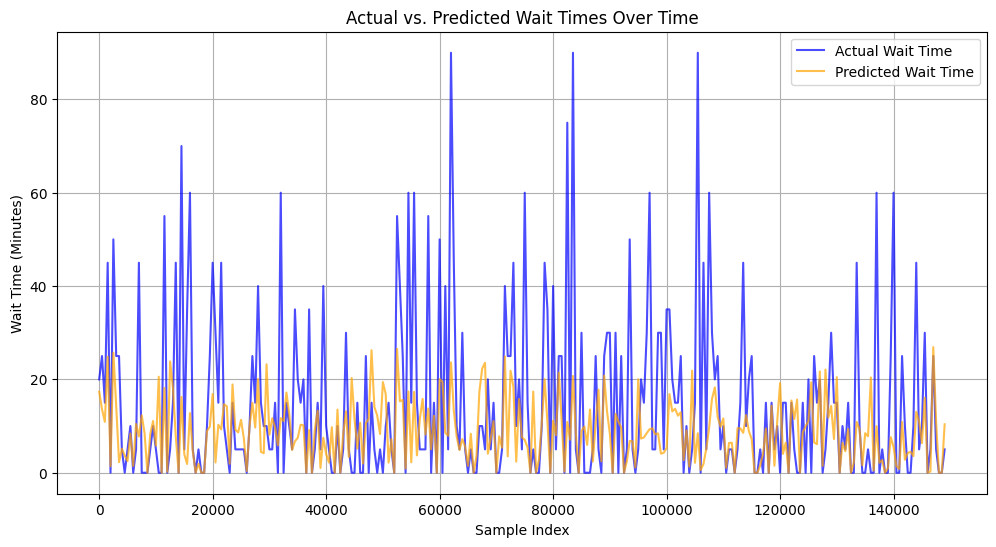

In [38]:
# Plot actual vs. predicted wait times
plt.figure(figsize=(12, 6))

plt.plot(prediction_sampled.index, prediction_sampled["y_test"], label="Actual Wait Time", color="blue", alpha=0.7)
plt.plot(prediction_sampled.index, prediction_sampled["y_pred"], label="Predicted Wait Time", color="orange", alpha=0.7)

plt.xlabel("Sample Index")  # No dates
plt.ylabel("Wait Time (Minutes)")
plt.title("Actual vs. Predicted Wait Times Over Time")
plt.legend()
plt.grid(True)

plt.show()

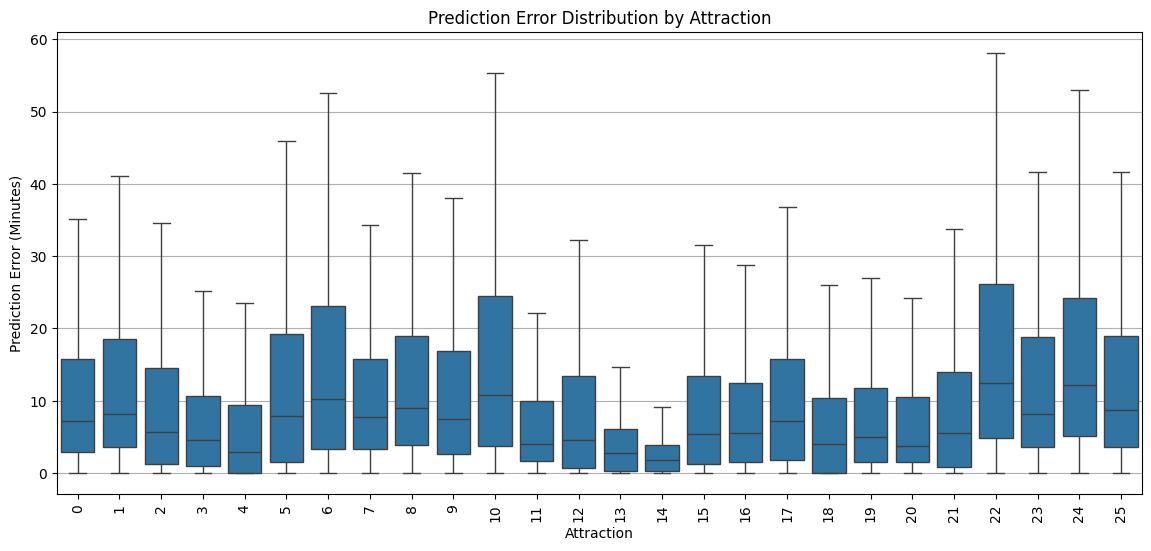

In [39]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=predictions_df, x="ENTITY_DESCRIPTION_SHORT", y="error", showfliers=False)  # Remove outliers for clarity

plt.xticks(rotation=90)
plt.xlabel("Attraction")
plt.ylabel("Prediction Error (Minutes)")
plt.title("Prediction Error Distribution by Attraction")
plt.grid(axis="y")
plt.show()


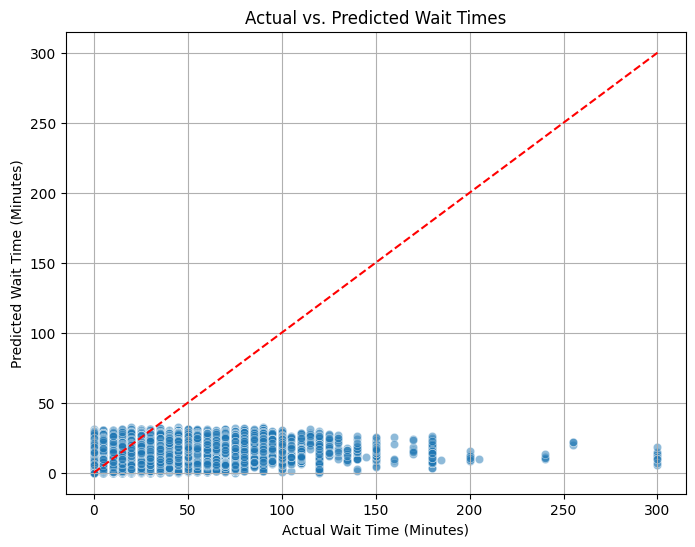

In [40]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=predictions_df["y_test"], y=predictions_df["y_pred"], alpha=0.5)

plt.plot([0, max(predictions_df["y_test"])], [0, max(predictions_df["y_test"])], color="red", linestyle="--")  # Ideal prediction line
plt.xlabel("Actual Wait Time (Minutes)")
plt.ylabel("Predicted Wait Time (Minutes)")
plt.title("Actual vs. Predicted Wait Times")
plt.grid(True)
plt.show()


In [ ]:
# Load event schedule
events = pd.read_csv("path_to_event_schedule.csv")

# Convert event times to datetime
events['event_time'] = pd.to_datetime(events['event_time'])

# Function to compute time difference to events
def compute_time_to_event(df, event_times, column_name):
    df[column_name] = df['datetime'].apply(lambda x: min((x - event).total_seconds() / 3600 for event in event_times))
    return df

# Compute for each event
expanded_df = compute_time_to_event(expanded_df, events[events['event_type'] == "Parade_1"]['event_time'], "TIME_TO_PARADE_1")
expanded_df = compute_time_to_event(expanded_df, events[events['event_type'] == "Parade_2"]['event_time'], "TIME_TO_PARADE_2")
expanded_df = compute_time_to_event(expanded_df, events[events['event_type'] == "Night_Show"]['event_time'], "TIME_TO_NIGHT_SHOW")


In [ ]:
# Load event schedule
events = pd.read_csv("path_to_event_schedule.csv")

# Convert event times to datetime
events['event_time'] = pd.to_datetime(events['event_time'])

# Function to compute time difference to events
def compute_time_to_event(df, event_times, column_name):
    df[column_name] = df['datetime'].apply(lambda x: min((x - event).total_seconds() / 3600 for event in event_times))
    return df

# Compute for each event
expanded_df = compute_time_to_event(expanded_df, events[events['event_type'] == "Parade_1"]['event_time'], "TIME_TO_PARADE_1")
expanded_df = compute_time_to_event(expanded_df, events[events['event_type'] == "Parade_2"]['event_time'], "TIME_TO_PARADE_2")
expanded_df = compute_time_to_event(expanded_df, events[events['event_type'] == "Night_Show"]['event_time'], "TIME_TO_NIGHT_SHOW")


In [ ]:
# Load historical data containing previous wait times
historical_df = pd.read_csv("path_to_historical_wait_times.csv")

# Merge previous wait times onto the expanded dataset
expanded_df = expanded_df.merge(historical_df[['datetime', 'attraction_id', 'WAIT_TIME_MAX']], 
                                on=['datetime', 'attraction_id'], how='left')

# Compute lag values
expanded_df['WAIT_LAG_1'] = expanded_df.groupby("attraction_id")['WAIT_TIME_MAX'].shift(1)
expanded_df['WAIT_LAG_2'] = expanded_df.groupby("attraction_id")['WAIT_LAG_1'].shift(1)
expanded_df['WAIT_LAG_3'] = expanded_df.groupby("attraction_id")['WAIT_LAG_2'].shift(1)

# Fill missing lag values for forecasted days
expanded_df[['WAIT_LAG_1', 'WAIT_LAG_2', 'WAIT_LAG_3']] = expanded_df[['WAIT_LAG_1', 'WAIT_LAG_2', 'WAIT_LAG_3']].fillna(method="ffill")


In [ ]:
attendance_forecast = pd.read_csv("path_to_attendance_forecast.csv")
expanded_df = expanded_df.merge(attendance_forecast, on="datetime", how="left")


In [ ]:
# Load attraction metadata (assuming it has these columns)
attraction_metadata = pd.read_csv("path_to_attraction_metadata.csv")

# Merge static attraction data
expanded_df = expanded_df.merge(attraction_metadata, on="attraction_id", how="left")

# If still missing, fill with historical averages
for col in ["NB_UNITS", "GUEST_CARRIED", "CAPACITY", "UP_TIME", "DOWNTIME"]:
    expanded_df[col] = expanded_df[col].fillna(expanded_df.groupby("attraction_id")[col].transform("mean"))


In [ ]:
expanded_df["datetime"] = pd.to_datetime(expanded_df["datetime"])
expanded_df["DEB_TIME_HOUR"] = expanded_df["datetime"].dt.hour


In [ ]:
# Load trained model
import joblib
model = joblib.load("path_to_trained_model.pkl")

# Make predictions
y_pred = model.predict(X_forecast)

# Store predictions
expanded_df["WAIT_TIME_PRED"] = y_pred

# Save results
expanded_df.to_csv("predicted_wait_times.csv", index=False)

print("✅ Predictions saved to 'predicted_wait_times.csv'")
